In [1]:
from __future__ import division
import os, sys
from sklearn.linear_model import *
from sklearn.svm import *
from sklearn.tree import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from keras.models import *
from keras.layers import Dense, Activation
from keras.optimizers import *
import threading
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve, roc_curve, auc

2024-04-07 01:44:56.023450: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 01:44:56.023573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 01:44:56.164870: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Connection**

In [5]:
df = pd.read_csv('/input/apaddos-dataset/APA-DDoS-Dataset/APA-DDoS-Dataset.csv')

In [6]:
df.head()

,ip.src,ip.dst,tcp.srcport,tcp.dstport,ip.proto,frame.len,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,...,tcp.seq,tcp.ack,frame.time,Packets,Bytes,Tx Packets,Tx Bytes,Rx Packets,Rx Bytes,Label
0,192.168.1.1,192.168.23.2,2412,8000,6,54,0,0,1,1,...,1,1,16-Jun 2020 20:18:15.071112000 Mountain Dayli...,8,432,4,216,4,216,DDoS-PSH-ACK
1,192.168.1.1,192.168.23.2,2413,8000,6,54,0,0,1,1,...,1,1,16-Jun 2020 20:18:15.071138000 Mountain Dayli...,10,540,5,270,5,270,DDoS-PSH-ACK
2,192.168.1.1,192.168.23.2,2414,8000,6,54,0,0,1,1,...,1,1,16-Jun 2020 20:18:15.071146000 Mountain Dayli...,12,648,6,324,6,324,DDoS-PSH-ACK
3,192.168.1.1,192.168.23.2,2415,8000,6,54,0,0,1,1,...,1,1,16-Jun 2020 20:18:15.071152000 Mountain Dayli...,10,540,5,270,5,270,DDoS-PSH-ACK
4,192.168.1.1,192.168.23.2,2416,8000,6,54,0,0,1,1,...,1,1,16-Jun 2020 20:18:15.071159000 Mountain Dayli...,6,324,3,162,3,162,DDoS-PSH-ACK


In [7]:
df.describe()

,tcp.srcport,tcp.dstport,ip.proto,frame.len,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,ip.flags.mf,ip.flags.df,ip.flags.rb,tcp.seq,tcp.ack,Packets,Bytes,Tx Packets,Tx Bytes,Rx Packets,Rx Bytes
count,151200.000000,151200.0,151200.0,151200.000000,151200.0,151200.0,151200.000000,151200.0,151200.0,151200.000000,151200.0,151200.0,151200.0,151200.000000,151200.000000,151200.000000,151200.000000,151200.000000,151200.000000
mean,27376.943247,8000.0,6.0,99.025126,0.0,0.0,0.500000,1.0,0.0,0.500000,0.0,1.0,1.0,9.082665,799.422937,5.048776,390.683981,4.033889,408.738955
std,19634.879546,0.0,0.0,71.226673,0.0,0.0,0.500002,0.0,0.0,0.500002,0.0,0.0,0.0,2.129620,373.759057,1.353814,177.223153,0.963107,197.105807
min,1302.000000,8000.0,6.0,54.000000,0.0,0.0,0.000000,1.0,0.0,0.000000,0.0,1.0,1.0,1.000000,54.000000,1.000000,54.000000,0.000000,0.000000
25%,8621.000000,8000.0,6.0,54.000000,0.0,0.0,0.000000,1.0,0.0,0.000000,0.0,1.0,1.0,8.000000,432.000000,4.000000,216.000000,4.000000,216.000000
50%,26263.000000,8000.0,6.0,60.000000,0.0,0.0,0.500000,1.0,0.0,0.500000,0.0,1.0,1.0,10.000000,1101.500000,6.000000,550.000000,4.000000,551.500000
75%,45566.000000,8000.0,6.0,105.000000,0.0,0.0,1.000000,1.0,0.0,1.000000,0.0,1.0,1.0,10.000000,1146.000000,6.000000,560.000000,4.000000,586.000000
max,60998.000000,8000.0,6.0,223.000000,0.0,0.0,1.000000,1.0,0.0,1.000000,0.0,1.0,1.0,20.000000,1229.000000,10.000000,561.000000,10.000000,668.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151200 entries, 0 to 151199
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip.src           151200 non-null  object
 1   ip.dst           151200 non-null  object
 2   tcp.srcport      151200 non-null  int64 
 3   tcp.dstport      151200 non-null  int64 
 4   ip.proto         151200 non-null  int64 
 5   frame.len        151200 non-null  int64 
 6   tcp.flags.syn    151200 non-null  int64 
 7   tcp.flags.reset  151200 non-null  int64 
 8   tcp.flags.push   151200 non-null  int64 
 9   tcp.flags.ack    151200 non-null  int64 
 10  ip.flags.mf      151200 non-null  int64 
 11  ip.flags.df      151200 non-null  int64 
 12  ip.flags.rb      151200 non-null  int64 
 13  tcp.seq          151200 non-null  int64 
 14  tcp.ack          151200 non-null  int64 
 15  frame.time       151200 non-null  object
 16  Packets          151200 non-null  int64 
 17  Bytes     

In [9]:
df.isnull().sum()

ip.src             0
ip.dst             0
tcp.srcport        0
tcp.dstport        0
ip.proto           0
frame.len          0
tcp.flags.syn      0
tcp.flags.reset    0
tcp.flags.push     0
tcp.flags.ack      0
ip.flags.mf        0
ip.flags.df        0
ip.flags.rb        0
tcp.seq            0
tcp.ack            0
frame.time         0
Packets            0
Bytes              0
Tx Packets         0
Tx Bytes           0
Rx Packets         0
Rx Bytes           0
Label              0
dtype: int64

In [10]:
df.columns

Index(['ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport', 'ip.proto',
       'frame.len', 'tcp.flags.syn', 'tcp.flags.reset', 'tcp.flags.push',
       'tcp.flags.ack', 'ip.flags.mf', 'ip.flags.df', 'ip.flags.rb', 'tcp.seq',
       'tcp.ack', 'frame.time', 'Packets', 'Bytes', 'Tx Packets', 'Tx Bytes',
       'Rx Packets', 'Rx Bytes', 'Label'],
      dtype='object')

# **Exploration Data Analysis**

In [11]:
df.isna().sum()

ip.src             0
ip.dst             0
tcp.srcport        0
tcp.dstport        0
ip.proto           0
frame.len          0
tcp.flags.syn      0
tcp.flags.reset    0
tcp.flags.push     0
tcp.flags.ack      0
ip.flags.mf        0
ip.flags.df        0
ip.flags.rb        0
tcp.seq            0
tcp.ack            0
frame.time         0
Packets            0
Bytes              0
Tx Packets         0
Tx Bytes           0
Rx Packets         0
Rx Bytes           0
Label              0
dtype: int64

In [12]:
df.duplicated().sum()

0

In [13]:
df.groupby('Label').size()

Label
Benign          75600
DDoS-ACK        37800
DDoS-PSH-ACK    37800
dtype: int64

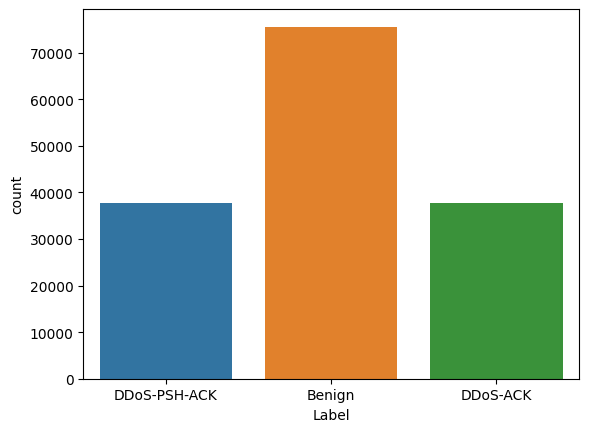

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# count plot on single categorical variable
sns.countplot(x = df["Label"])

# Show the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


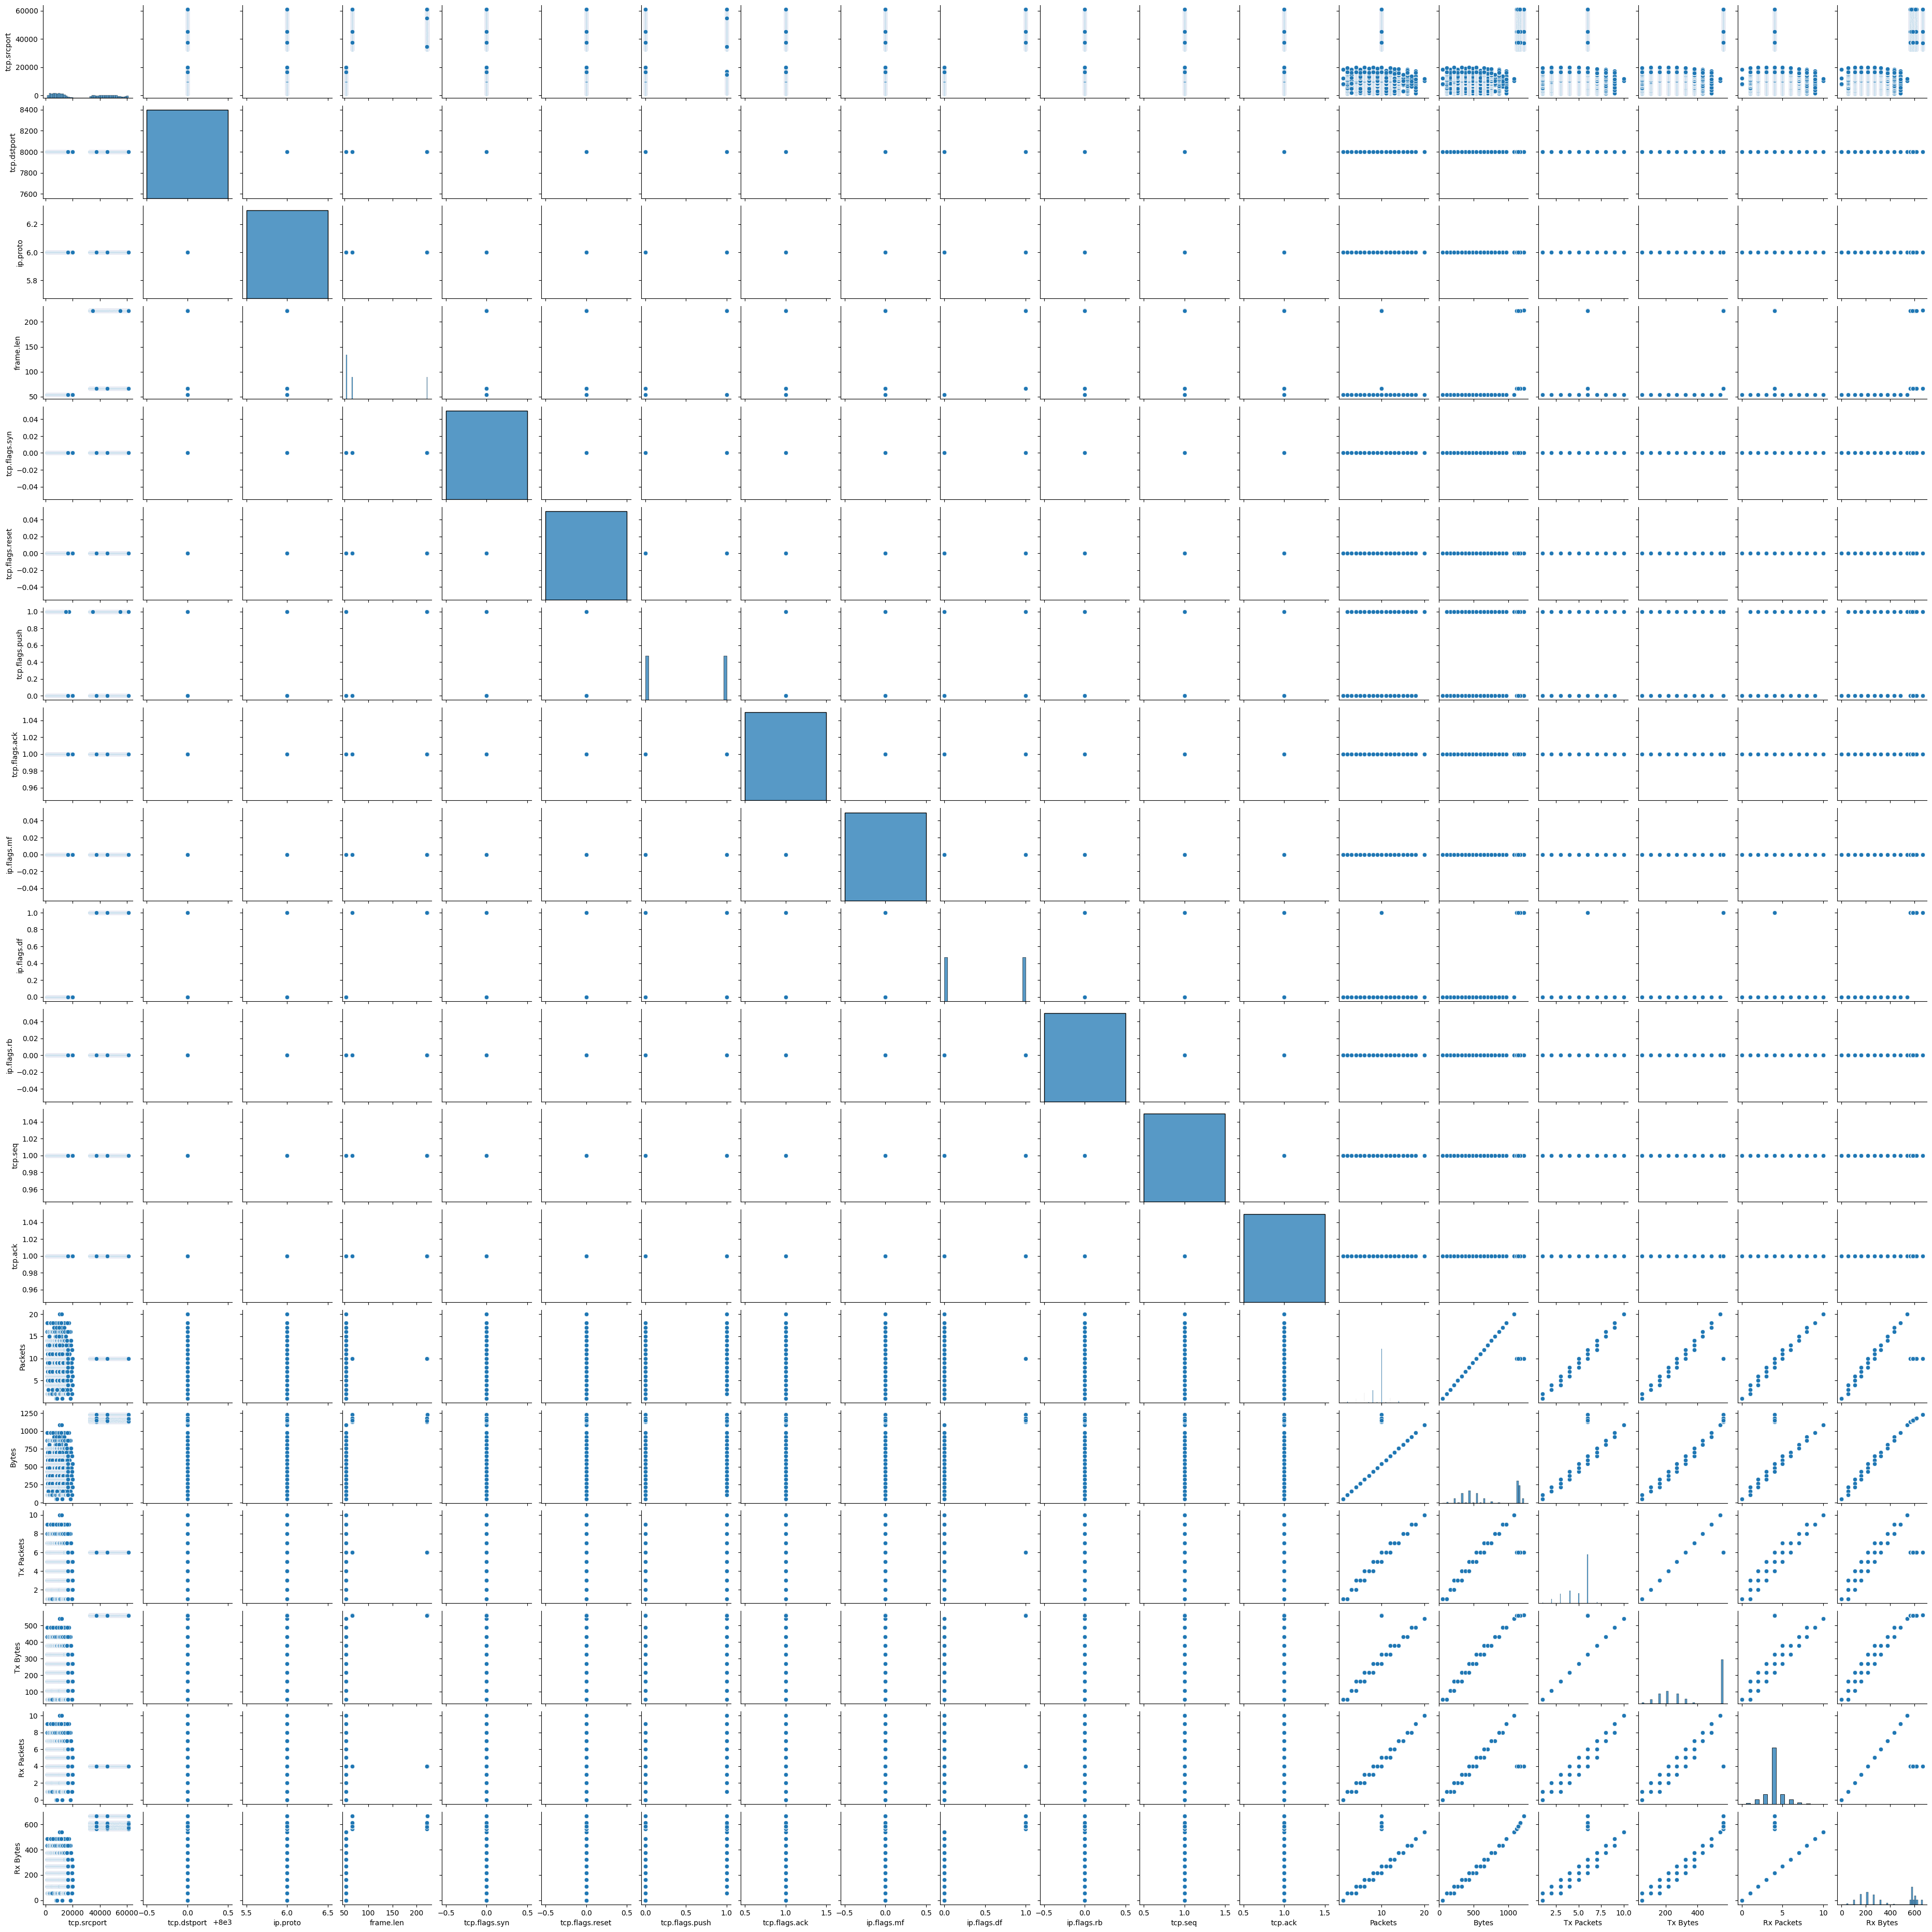

In [12]:
sns.pairplot(df, size=2)

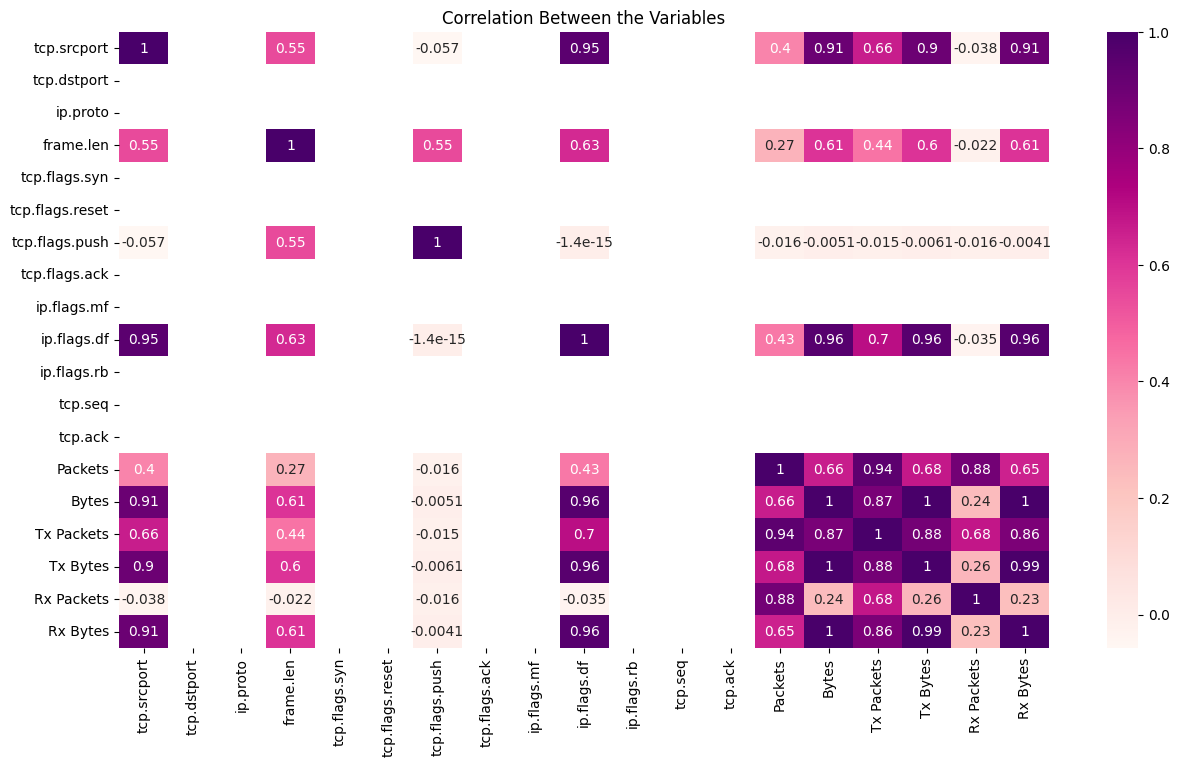

In [15]:
numeric_data = df.select_dtypes(include='number')# select only the columns in the DataFrame data that have numeric (number) data
correlation_matrix = numeric_data.corr()
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(correlation_matrix, annot=True,ax=ax,  cmap="RdPu")
plt.title('Correlation Between the Variables')
#plt.xticks(rotation=45);
plt.show()

# **Data Pre-Processing**

In [16]:
data_new = df.drop(columns=['tcp.dstport', 'ip.proto', 'tcp.flags.syn', 
                     'tcp.flags.reset', 'tcp.flags.ack', 'ip.flags.mf', 
                     'ip.flags.rb', 'tcp.seq', 'tcp.ack', 'frame.time'])
data_new

,ip.src,ip.dst,tcp.srcport,frame.len,tcp.flags.push,ip.flags.df,Packets,Bytes,Tx Packets,Tx Bytes,Rx Packets,Rx Bytes,Label
0,192.168.1.1,192.168.23.2,2412,54,1,0,8,432,4,216,4,216,DDoS-PSH-ACK
1,192.168.1.1,192.168.23.2,2413,54,1,0,10,540,5,270,5,270,DDoS-PSH-ACK
2,192.168.1.1,192.168.23.2,2414,54,1,0,12,648,6,324,6,324,DDoS-PSH-ACK
3,192.168.1.1,192.168.23.2,2415,54,1,0,10,540,5,270,5,270,DDoS-PSH-ACK
4,192.168.1.1,192.168.23.2,2416,54,1,0,6,324,3,162,3,162,DDoS-PSH-ACK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151195,192.168.19.1,192.168.23.2,37360,66,0,1,10,1146,6,560,4,586,Benign
151196,192.168.19.1,192.168.23.2,37362,66,0,1,10,1151,6,560,4,591,Benign
151197,192.168.19.1,192.168.23.2,37364,66,0,1,10,1144,6,560,4,584,Benign
151198,192.168.19.1,192.168.23.2,37366,66,0,1,10,1175,6,560,4,615,Benign


In [44]:
# Assuming your DataFrame is named df
#data_new['Label_new'] = data_new['Label'].apply(lambda x: 'Benign' if x == 'Benign' else 'DDoS')
#data_new.drop(columns=['Label'], inplace=True)
#data_new.rename(columns={'Label_new': 'Label'}, inplace=True)
#data_new

,ip.src,ip.dst,tcp.srcport,frame.len,tcp.flags.push,ip.flags.df,Packets,Bytes,Tx Packets,Tx Bytes,Rx Packets,Rx Bytes,Label
0,192.168.1.1,192.168.23.2,2412,54,1,0,8,432,4,216,4,216,DDoS
1,192.168.1.1,192.168.23.2,2413,54,1,0,10,540,5,270,5,270,DDoS
2,192.168.1.1,192.168.23.2,2414,54,1,0,12,648,6,324,6,324,DDoS
3,192.168.1.1,192.168.23.2,2415,54,1,0,10,540,5,270,5,270,DDoS
4,192.168.1.1,192.168.23.2,2416,54,1,0,6,324,3,162,3,162,DDoS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151195,192.168.19.1,192.168.23.2,37360,66,0,1,10,1146,6,560,4,586,Benign
151196,192.168.19.1,192.168.23.2,37362,66,0,1,10,1151,6,560,4,591,Benign
151197,192.168.19.1,192.168.23.2,37364,66,0,1,10,1144,6,560,4,584,Benign
151198,192.168.19.1,192.168.23.2,37366,66,0,1,10,1175,6,560,4,615,Benign


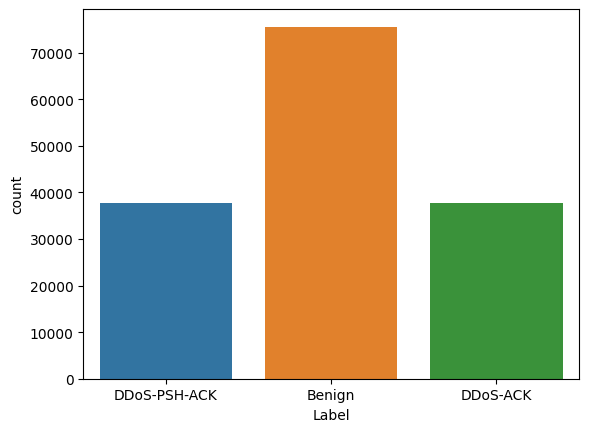

In [17]:
# count plot on single categorical variable
sns.countplot(x = data_new["Label"])

# Show the plot
plt.show()

In [18]:
X=data_new.drop(columns=['Label'])
X

,ip.src,ip.dst,tcp.srcport,frame.len,tcp.flags.push,ip.flags.df,Packets,Bytes,Tx Packets,Tx Bytes,Rx Packets,Rx Bytes
0,192.168.1.1,192.168.23.2,2412,54,1,0,8,432,4,216,4,216
1,192.168.1.1,192.168.23.2,2413,54,1,0,10,540,5,270,5,270
2,192.168.1.1,192.168.23.2,2414,54,1,0,12,648,6,324,6,324
3,192.168.1.1,192.168.23.2,2415,54,1,0,10,540,5,270,5,270
4,192.168.1.1,192.168.23.2,2416,54,1,0,6,324,3,162,3,162
...,...,...,...,...,...,...,...,...,...,...,...,...
151195,192.168.19.1,192.168.23.2,37360,66,0,1,10,1146,6,560,4,586
151196,192.168.19.1,192.168.23.2,37362,66,0,1,10,1151,6,560,4,591
151197,192.168.19.1,192.168.23.2,37364,66,0,1,10,1144,6,560,4,584
151198,192.168.19.1,192.168.23.2,37366,66,0,1,10,1175,6,560,4,615


In [19]:
y = data_new["Label"]
Y = y
y

0         DDoS-PSH-ACK
1         DDoS-PSH-ACK
2         DDoS-PSH-ACK
3         DDoS-PSH-ACK
4         DDoS-PSH-ACK
              ...     
151195          Benign
151196          Benign
151197          Benign
151198          Benign
151199          Benign
Name: Label, Length: 151200, dtype: object

In [38]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y

array([2, 2, 2, ..., 0, 0, 0])

In [21]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
X = data_new.drop(columns=['Label']).copy()


categorical_columns = ['ip.src', 'ip.dst']# Select categorical columns for one-hot encoding

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough'
)


pipeline = Pipeline(steps=[('preprocessor', preprocessor)])# Create a pipeline


X_encoded = pipeline.fit_transform(X)# Fit and transform

# Get the column names after encoding
encoded_column_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_columns)
column_names = list(encoded_column_names) + list(X.columns.difference(categorical_columns))


X = pd.DataFrame(X_encoded, columns=column_names)
X

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,ip.src_192.168.1.1,ip.src_192.168.10.1,ip.src_192.168.11.1,ip.src_192.168.13.1,ip.src_192.168.14.1,ip.src_192.168.16.1,ip.src_192.168.17.1,ip.src_192.168.19.1,ip.src_192.168.2.1,ip.src_192.168.20.1,...,Bytes,Packets,Rx Bytes,Rx Packets,Tx Bytes,Tx Packets,frame.len,ip.flags.df,tcp.flags.push,tcp.srcport
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2412.0,54.0,1.0,0.0,8.0,432.0,4.0,216.0,4.0,216.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2413.0,54.0,1.0,0.0,10.0,540.0,5.0,270.0,5.0,270.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2414.0,54.0,1.0,0.0,12.0,648.0,6.0,324.0,6.0,324.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2415.0,54.0,1.0,0.0,10.0,540.0,5.0,270.0,5.0,270.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2416.0,54.0,1.0,0.0,6.0,324.0,3.0,162.0,3.0,162.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,37360.0,66.0,0.0,1.0,10.0,1146.0,6.0,560.0,4.0,586.0
151196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,37362.0,66.0,0.0,1.0,10.0,1151.0,6.0,560.0,4.0,591.0
151197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,37364.0,66.0,0.0,1.0,10.0,1144.0,6.0,560.0,4.0,584.0
151198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,37366.0,66.0,0.0,1.0,10.0,1175.0,6.0,560.0,4.0,615.0


# **Model Training**

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)# Split the data into training and testing sets

In [23]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 120960 entries, 39462 to 121958
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ip.src_192.168.1.1   120960 non-null  float64
 1   ip.src_192.168.10.1  120960 non-null  float64
 2   ip.src_192.168.11.1  120960 non-null  float64
 3   ip.src_192.168.13.1  120960 non-null  float64
 4   ip.src_192.168.14.1  120960 non-null  float64
 5   ip.src_192.168.16.1  120960 non-null  float64
 6   ip.src_192.168.17.1  120960 non-null  float64
 7   ip.src_192.168.19.1  120960 non-null  float64
 8   ip.src_192.168.2.1   120960 non-null  float64
 9   ip.src_192.168.20.1  120960 non-null  float64
 10  ip.src_192.168.4.1   120960 non-null  float64
 11  ip.src_192.168.5.1   120960 non-null  float64
 12  ip.src_192.168.7.1   120960 non-null  float64
 13  ip.src_192.168.8.1   120960 non-null  float64
 14  ip.dst_192.168.23.2  120960 non-null  float64
 15  Bytes             

In [24]:
X_train

,ip.src_192.168.1.1,ip.src_192.168.10.1,ip.src_192.168.11.1,ip.src_192.168.13.1,ip.src_192.168.14.1,ip.src_192.168.16.1,ip.src_192.168.17.1,ip.src_192.168.19.1,ip.src_192.168.2.1,ip.src_192.168.20.1,...,Bytes,Packets,Rx Bytes,Rx Packets,Tx Bytes,Tx Packets,frame.len,ip.flags.df,tcp.flags.push,tcp.srcport
39462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,34562.0,223.0,1.0,1.0,10.0,1229.0,6.0,561.0,4.0,668.0
86399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13220.0,54.0,0.0,0.0,10.0,540.0,5.0,270.0,5.0,270.0
46424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40372.0,223.0,1.0,1.0,10.0,1229.0,6.0,561.0,4.0,668.0
123679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,54482.0,66.0,0.0,1.0,10.0,1170.0,6.0,560.0,4.0,610.0
23643,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,5706.0,54.0,1.0,0.0,8.0,432.0,4.0,216.0,4.0,216.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,46882.0,66.0,0.0,1.0,10.0,1151.0,6.0,560.0,4.0,591.0
103694,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6153.0,54.0,0.0,0.0,10.0,540.0,5.0,270.0,5.0,270.0
131932,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,46358.0,66.0,0.0,1.0,10.0,1229.0,6.0,561.0,4.0,668.0
146867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,56936.0,66.0,0.0,1.0,10.0,1151.0,6.0,560.0,4.0,591.0


In [59]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30240 entries, 90870 to 65194
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ip.src_192.168.1.1   30240 non-null  float64
 1   ip.src_192.168.10.1  30240 non-null  float64
 2   ip.src_192.168.11.1  30240 non-null  float64
 3   ip.src_192.168.13.1  30240 non-null  float64
 4   ip.src_192.168.14.1  30240 non-null  float64
 5   ip.src_192.168.16.1  30240 non-null  float64
 6   ip.src_192.168.17.1  30240 non-null  float64
 7   ip.src_192.168.19.1  30240 non-null  float64
 8   ip.src_192.168.2.1   30240 non-null  float64
 9   ip.src_192.168.20.1  30240 non-null  float64
 10  ip.src_192.168.4.1   30240 non-null  float64
 11  ip.src_192.168.5.1   30240 non-null  float64
 12  ip.src_192.168.7.1   30240 non-null  float64
 13  ip.src_192.168.8.1   30240 non-null  float64
 14  ip.dst_192.168.23.2  30240 non-null  float64
 15  Bytes                30240 non-null  

In [25]:
X_test

,ip.src_192.168.1.1,ip.src_192.168.10.1,ip.src_192.168.11.1,ip.src_192.168.13.1,ip.src_192.168.14.1,ip.src_192.168.16.1,ip.src_192.168.17.1,ip.src_192.168.19.1,ip.src_192.168.2.1,ip.src_192.168.20.1,...,Bytes,Packets,Rx Bytes,Rx Packets,Tx Bytes,Tx Packets,frame.len,ip.flags.df,tcp.flags.push,tcp.srcport
90870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16271.0,54.0,0.0,0.0,6.0,324.0,3.0,162.0,3.0,162.0
118547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,52332.0,66.0,0.0,1.0,10.0,1144.0,6.0,560.0,4.0,584.0
43005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,41648.0,222.0,1.0,1.0,10.0,1168.0,6.0,560.0,4.0,608.0
72756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,49114.0,222.0,1.0,1.0,10.0,1168.0,6.0,560.0,4.0,608.0
98003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3200.0,54.0,0.0,0.0,12.0,648.0,6.0,324.0,6.0,324.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11282.0,54.0,0.0,0.0,6.0,324.0,3.0,162.0,3.0,162.0
81702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4278.0,54.0,0.0,0.0,6.0,324.0,3.0,162.0,3.0,162.0
13738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9677.0,54.0,1.0,0.0,10.0,540.0,5.0,270.0,5.0,270.0
66967,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56364.0,222.0,1.0,1.0,10.0,1175.0,6.0,560.0,4.0,615.0


In [35]:
y_train


array([0, 1, 0, ..., 0, 0, 0])

In [27]:
y_test

array([1, 0, 0, ..., 2, 0, 0])

In [36]:
import numpy as np
class_counts = np.bincount(y_train)
print(f'Count for class 0 (Benign): {class_counts[0]}')
print(f'Count for class 1 (DDoS-ACK): {class_counts[1]}')
print(f'Count for class 2 (DDoS-PSH-ACK): {class_counts[2]}')

Count for class 0 (Benign): 60431
Count for class 1 (DDoS-ACK): 30192
Count for class 2 (DDoS-PSH-ACK): 30337


# **Machine Learning**

# **Decision Tree**

In [107]:
from sklearn.metrics import accuracy_score,confusion_matrix
decision_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=20)
decision_tree_model.fit(X_train, y_train)
y_pred_decision_tree = decision_tree_model.predict(X_test)
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
print("Training accuracy score of the model is:",accuracy_score(y_train, decision_tree_model.predict(X_train))*100,"%")
print("Testing accuracy score of the model is:",accuracy_score(y_test,y_pred_decision_tree)*100,"%")

Training accuracy score of the model is: 100.0 %
Testing accuracy score of the model is: 100.0 %


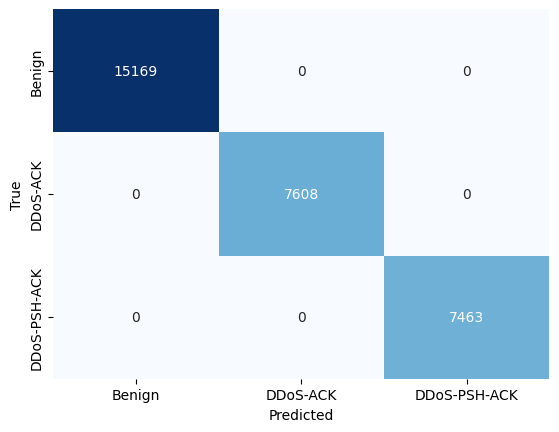

In [106]:
DT_cm = confusion_matrix(y_test, y_pred_decision_tree)
import seaborn as sns
class_labels = ["Benign", "DDoS-ACK", "DDoS-PSH-ACK"]
sns.heatmap(DT_cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [43]:
print ('Classification Report : ')
print (classification_report(y_test, y_pred_decision_tree))

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15169
           1       1.00      1.00      1.00      7608
           2       1.00      1.00      1.00      7463

    accuracy                           1.00     30240
   macro avg       1.00      1.00      1.00     30240
weighted avg       1.00      1.00      1.00     30240



In [127]:
def perf_measure(y_test, y_pred_decision_tree):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred_decision_tree)): 
        if y_test[i]==y_pred_decision_tree[i]==1:
           TP += 1
        if y_pred_decision_tree[i]==1 and y_test[i]!=y_pred_decision_tree[i]:
           FP += 1
        if y_test[i]==y_pred_decision_tree[i]==0:
           TN += 1
        if y_pred_decision_tree[i]==0 and y_test[i]!=y_pred_decision_tree[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [128]:
A = perf_measure(y_test, y_pred_decision_tree)
A

(15071, 0, 15169, 0)

# K Nearest Neighbour

In [108]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=30)

knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=30)

In [109]:
from sklearn.metrics import accuracy_score,confusion_matrix
y_pred = knn.predict(X_test)
knn_acc=accuracy_score(y_test,y_pred)
knn_acc
print("Training accuracy score of the model is:",accuracy_score(y_train, knn.predict(X_train))*100,"%")
print("Testing accuracy score of the model is:",accuracy_score(y_test,y_pred)*100,"%")

Training accuracy score of the model is: 82.98445767195767 %
Testing accuracy score of the model is: 80.83002645502646 %


In [49]:
knn_cm=confusion_matrix(y_test,y_pred)
print("Confusion matrix of the model \n",knn_cm)

Confusion matrix of the model 
 [[15169     0     0]
 [    0  4734  2874]
 [    0  2923  4540]]


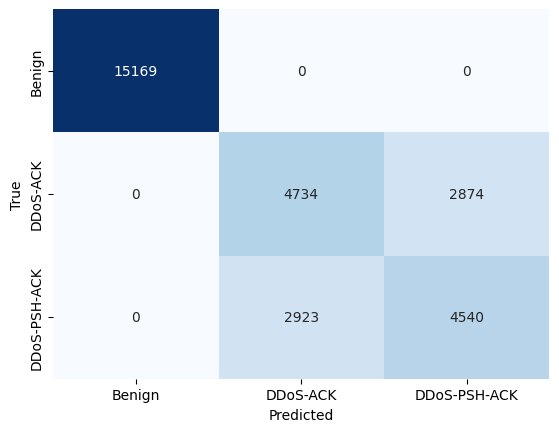

In [50]:
import seaborn as sns
class_labels = ["Benign", "DDoS-ACK", "DDoS-PSH-ACK"]
sns.heatmap(knn_cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [110]:
print ('Classification Report : ')
print (classification_report(y_test, y_pred))

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15169
           1       0.62      0.62      0.62      7608
           2       0.61      0.61      0.61      7463

    accuracy                           0.81     30240
   macro avg       0.74      0.74      0.74     30240
weighted avg       0.81      0.81      0.81     30240



# Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2')
lr.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [53]:
from sklearn.metrics import accuracy_score,confusion_matrix

y_pred = lr.predict(X_test)

acc=accuracy_score(y_test,y_pred)
acc

0.8674272486772486

In [54]:
print("Training accuracy score of the model is:",accuracy_score(y_train, lr.predict(X_train))*100,"%")
print("Testing accuracy score of the model is:",accuracy_score(y_test,y_pred)*100,"%")

Training accuracy score of the model is: 86.45667989417989 %
Testing accuracy score of the model is: 86.74272486772486 %


In [55]:
LOR_cm=confusion_matrix(y_test,y_pred)
print("Confusion matrix of the model \n",LOR_cm)

Confusion matrix of the model 
 [[15169     0     0]
 [    0  5055  2553]
 [    0  1456  6007]]


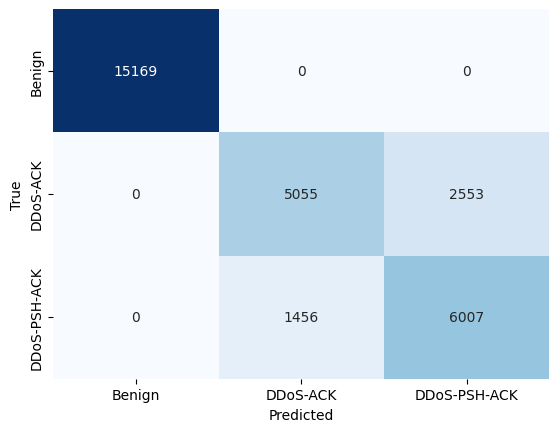

In [56]:
import seaborn as sns
class_labels = ["Benign", "DDoS-ACK", "DDoS-PSH-ACK"]
sns.heatmap(LOR_cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [57]:
print ('Classification Report : ')
print (classification_report(y_test, y_pred))

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15169
           1       0.78      0.66      0.72      7608
           2       0.70      0.80      0.75      7463

    accuracy                           0.87     30240
   macro avg       0.83      0.82      0.82     30240
weighted avg       0.87      0.87      0.87     30240



# Support Vector Machine

In [58]:
from sklearn.svm import SVC

svc = SVC(probability=True)
svc.fit(X_train, y_train)


SVC(probability=True)

In [59]:
from sklearn.metrics import accuracy_score,confusion_matrix

y_pred = svc.predict(X_test)

svc_acc=accuracy_score(y_test,y_pred)

svc_acc


0.7688822751322751

In [60]:
print("Training accuracy score of the model is:",accuracy_score(y_train, svc.predict(X_train))*100,"%")


print("Testing accuracy score of the model is:",accuracy_score(y_test,y_pred)*100,"%")

Training accuracy score of the model is: 76.62450396825396 %
Testing accuracy score of the model is: 76.88822751322752 %


In [61]:
svc_cm=confusion_matrix(y_test,y_pred)
print("Confusion matrix of the model \n",svc_cm)

Confusion matrix of the model 
 [[15169     0     0]
 [    0  2020  5588]
 [    0  1401  6062]]


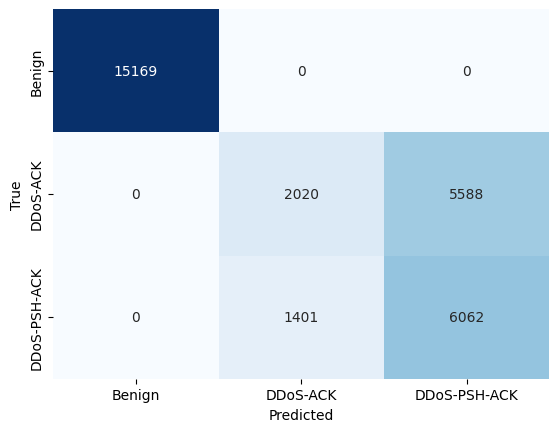

In [62]:
import seaborn as sns
class_labels = ["Benign", "DDoS-ACK", "DDoS-PSH-ACK"]
sns.heatmap(svc_cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [63]:
print ('Classification Report : ')
print (classification_report(y_test, y_pred))

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15169
           1       0.59      0.27      0.37      7608
           2       0.52      0.81      0.63      7463

    accuracy                           0.77     30240
   macro avg       0.70      0.69      0.67     30240
weighted avg       0.78      0.77      0.75     30240



# Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion = 'gini', max_depth = 1, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 4, n_estimators = 10)
rfc.fit(X_train, y_train)


RandomForestClassifier(max_depth=1, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=10)

In [69]:
y_pred = rfc.predict(X_test)

rfc_acc=accuracy_score(y_test,y_pred)

rfc_acc

0.7484126984126984

In [70]:
print("Training accuracy score of the model is:",accuracy_score(y_train, rfc.predict(X_train))*100,"%")
print("Testing accuracy score of the model is:",accuracy_score(y_test,y_pred)*100,"%")

Training accuracy score of the model is: 75.03968253968254 %
Testing accuracy score of the model is: 74.84126984126985 %


In [71]:
rfc_cm=confusion_matrix(y_test,y_pred)
print("Confusion matrix of the model \n",rfc_cm)

Confusion matrix of the model 
 [[15169     0     0]
 [    0     0  7608]
 [    0     0  7463]]


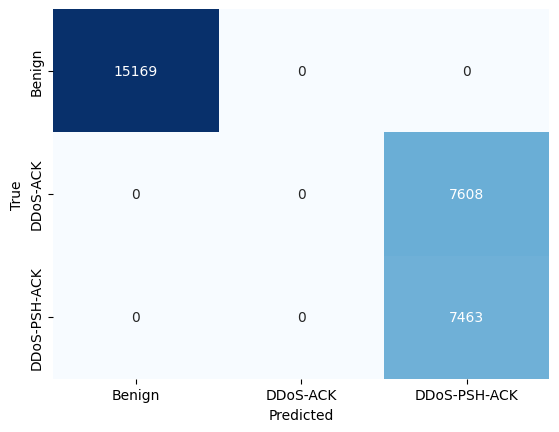

In [72]:
import seaborn as sns
class_labels = ["Benign", "DDoS-ACK", "DDoS-PSH-ACK"]
sns.heatmap(rfc_cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [73]:
print ('Classification Report : ')
print (classification_report(y_test, y_pred))

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15169
           1       0.00      0.00      0.00      7608
           2       0.50      1.00      0.66      7463

    accuracy                           0.75     30240
   macro avg       0.50      0.67      0.55     30240
weighted avg       0.62      0.75      0.67     30240



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
